<a href="https://colab.research.google.com/github/kumarprakhar14/Brain-Tumor-Classification/blob/main/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # -1  to USE CPU
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os

get_ipython().magic(u'matplotlib inline')

In [ ]:
# Renaming the dataset
import os

folder = '/content/drive/MyDrive/Task2/train/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files are renamed in yes dir")

All files are renamed in yes dir


In [ ]:
folder = '/content/drive/MyDrive/Task2/train/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files are renamed in no dir")

All files are renamed in no dir


In [ ]:
folder = '/content/drive/MyDrive/Task2/test/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Test_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files are renamed in yes dir")

All files are renamed in yes dir


Preprocessing

In [ ]:
# Cropping the image

def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image

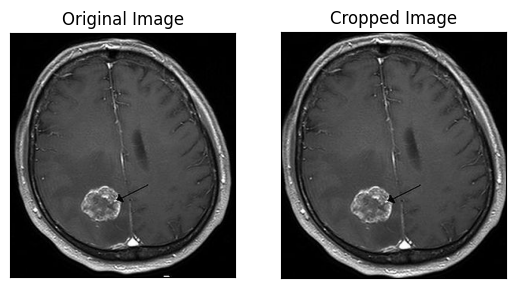

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/Task2/train/yes/Y_11.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in os.listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # print(image)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y

In [ ]:
augmented_path = '/content/drive/MyDrive/Task2/train/'
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Y_17.jpg
/content/drive/MyDrive/Task2/train/yes
Y_14.jpg
/content/drive/MyDrive/Task2/train/yes
Y_13.jpg
/content/drive/MyDrive/Task2/train/yes
Y_10.jpg
/content/drive/MyDrive/Task2/train/yes
Y_11.jpg
/content/drive/MyDrive/Task2/train/yes
Y_12.jpg
/content/drive/MyDrive/Task2/train/yes
Y_33.jpg
/content/drive/MyDrive/Task2/train/yes
Y_32.jpg
/content/drive/MyDrive/Task2/train/yes
Y_31.jpg
/content/drive/MyDrive/Task2/train/yes
Y_28.jpg
/content/drive/MyDrive/Task2/train/yes
Y_29.jpg
/content/drive/MyDrive/Task2/train/yes
Y_26.jpg
/content/drive/MyDrive/Task2/train/yes
Y_27.jpg
/content/drive/MyDrive/Task2/train/yes
Y_30.jpg
/content/drive/MyDrive/Task2/train/yes
Y_24.jpg
/content/drive/MyDrive/Task2/train/yes
Y_20.jpg
/content/drive/MyDrive/Task2/train/yes
Y_25.jpg
/content/drive/MyDrive/Task2/train/yes
Y_63.jpg
/content/drive/MyDrive/Task2/train/yes
Y_64.jpg
/content/drive/MyDrive/Task2/train/yes
Y_62.jpg
/content/drive/MyDrive/Task2/train/yes
Y_60.jpg
/content/drive/MyDrive/Task2/tr

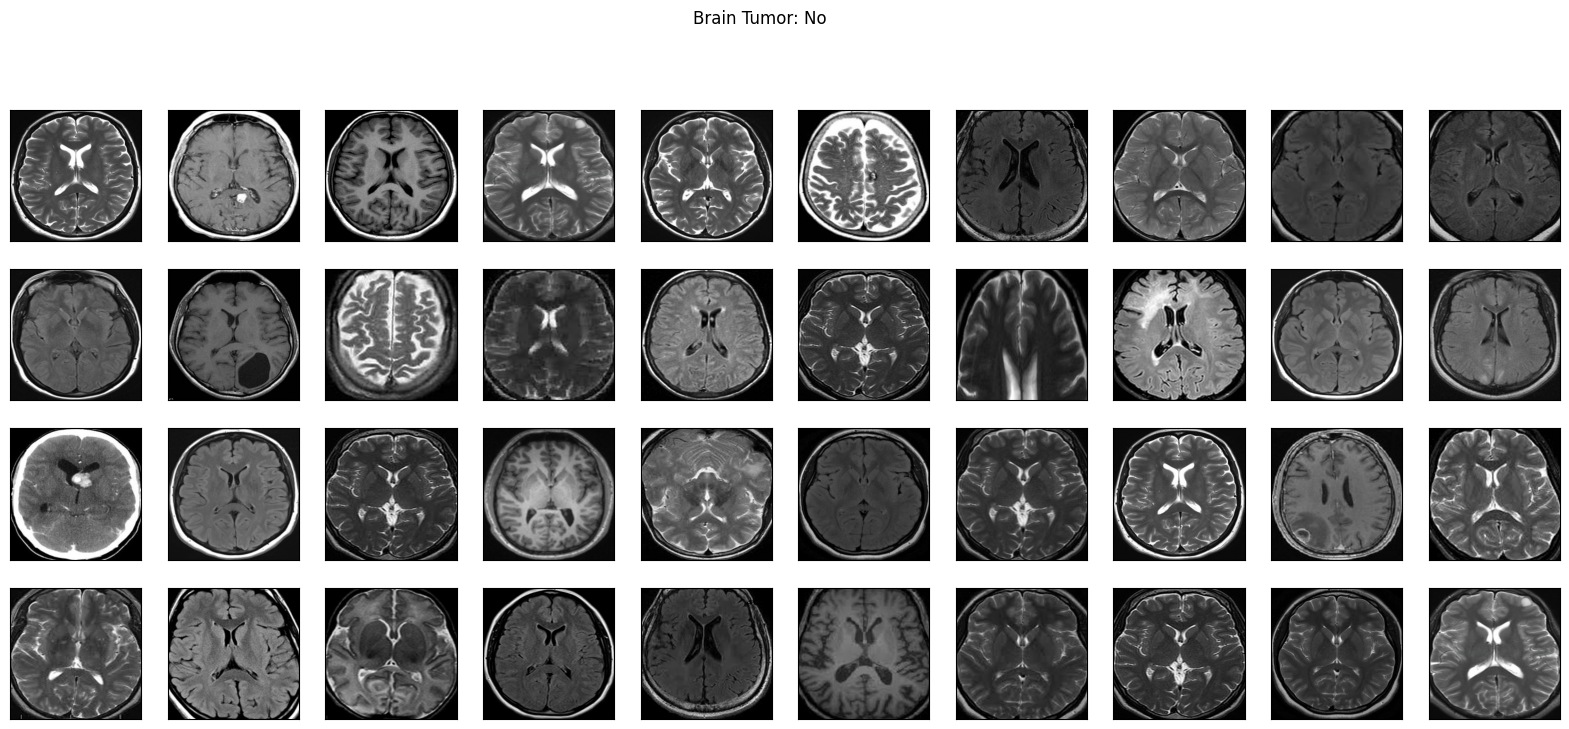

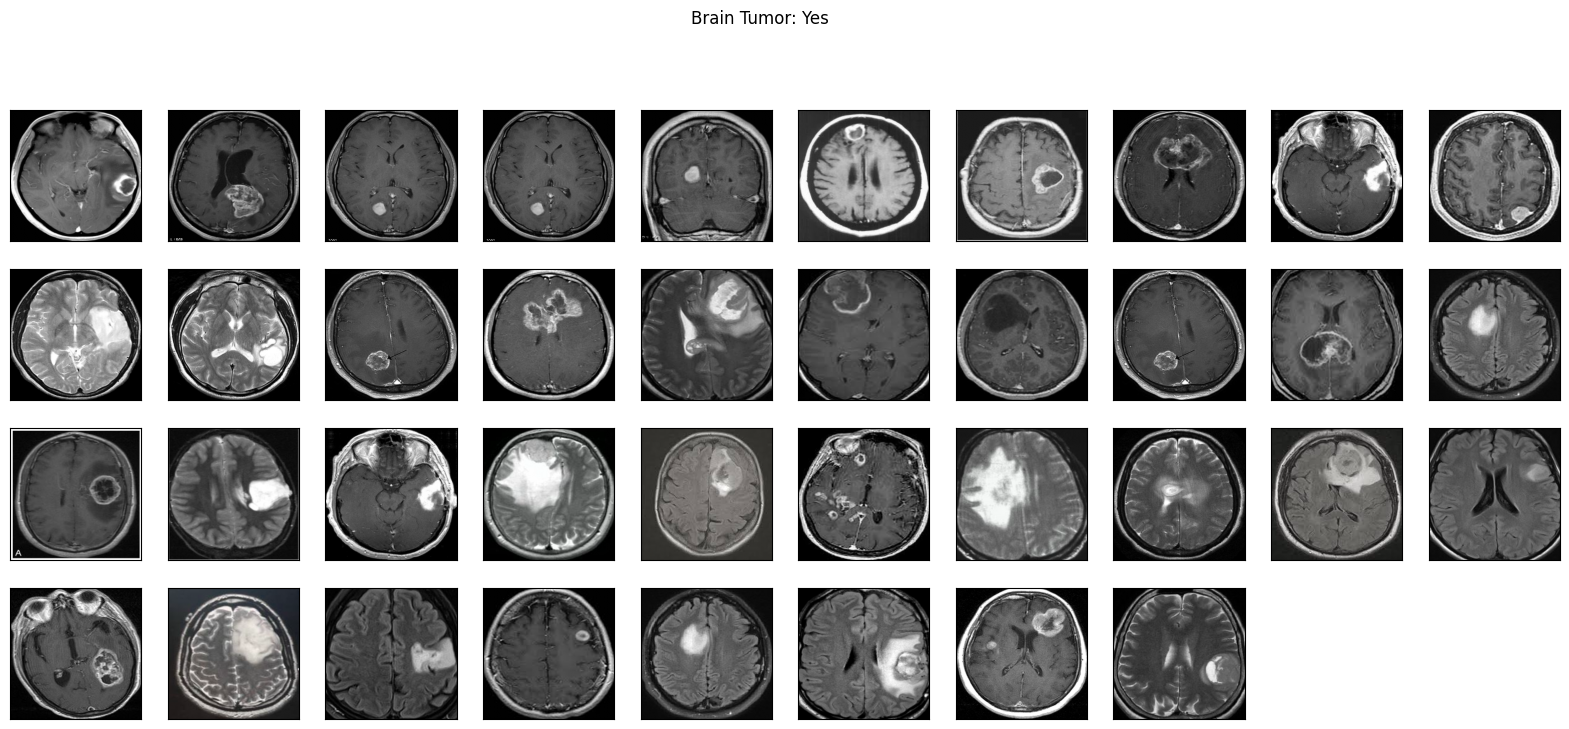

In [ ]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle("Brain Tumor: {}".format(label_to_str(label)))
        plt.show()

plot_sample_images(X, y)

In [ ]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 54
number of development examples = 12
number of test examples = 12
X_train shape: (54, 240, 240, 3)
Y_train shape: (54, 1)
X_val (dev) shape: (12, 240, 240, 3)
Y_val (dev) shape: (12, 1)
X_test shape: (12, 240, 240, 3)
Y_test shape: (12, 1)


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{}:{}".format(h,m,round(s,1))

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)

    return score

In [ ]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) #

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X) #
    # X=Dropout(0.50)(X)


    X = Conv2D(128, (5, 5), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)  # shape=(?, 238, 238, 32)
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    X=Dropout(0.50)(X)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)


    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 64)      1792      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 64)      256       
                                                                 
 activation (Activation)     (None, 238, 238, 64)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 119, 119, 64)      0         
                                                                 
 conv1 (Conv2D)              (None, 58, 58, 128)       204928    
                                                                 
 bn1 (BatchNormalization)    (None, 58, 58, 128

In [ ]:
import time
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# tensorboard
log_file_name = 'brain_tumor_detection_cnn_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_file_name))

# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# model.compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[reduce_lr,tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))

Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 2.1685 - accuracy: 0.5000 
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to cnn-parameters-improvement-01-0.42.keras
2/2 [==============================] - 19s 5s/step - loss: 2.1685 - accuracy: 0.5000 - val_loss: 0.6863 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 4.3229 - accuracy: 0.5185
Epoch 2: val_accuracy improved from 0.41667 to 0.58333, saving model to cnn-parameters-improvement-02-0.58.keras
2/2 [==============================] - 14s 6s/step - loss: 4.3229 - accuracy: 0.5185 - val_loss: 0.6552 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.7778
Epoch 3: val_accuracy did not improve from 0.58333
2/2 [==============================] - 13s 7s/step - loss: 0.7120 - accuracy: 0.7778 - val_loss: 0.6593 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/30
2/2 [=============

In [ ]:
history = model.history.history

for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy
lr


In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

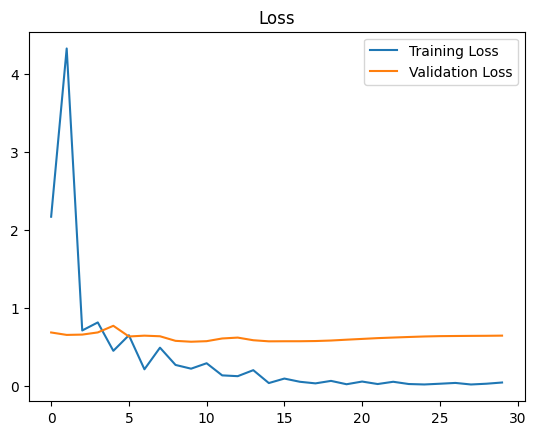

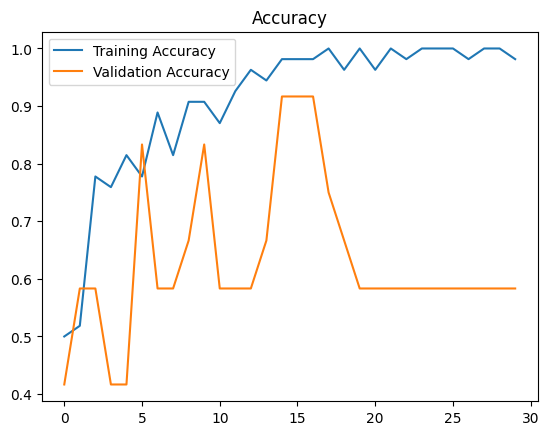

In [ ]:
plot_metrics(history)

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
loss, compile_metrics = model.evaluate(x=X_test, y=y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.8309 - accuracy: 0.4167


In [ ]:
print ("Test Loss = {}".format(loss))
print ("Test Accuracy = {}".format(compile_metrics))

Test Loss = 0.8308942914009094
Test Accuracy = 0.4166666567325592


In [ ]:
y_test_prob = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)

In [ ]:
y_val_prob = model.predict(X_val)

1/1 [==============================] - 1s 1s/step


In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)

In [ ]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [ ]:
data_percentage(y)

Number of examples:78
Percentage of positive examples: 48.717948717948715%, number of pos examples: 38
Percentage of negative examples: 51.282051282051285%, number of neg examples: 40


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples:54
Percentage of positive examples: 48.148148148148145%, number of pos examples: 26
Percentage of negative examples: 51.851851851851855%, number of neg examples: 28
Validation Data:
Number of examples:12
Percentage of positive examples: 58.333333333333336%, number of pos examples: 7
Percentage of negative examples: 41.666666666666664%, number of neg examples: 5
Testing Data:
Number of examples:12
Percentage of positive examples: 41.666666666666664%, number of pos examples: 5
Percentage of negative examples: 58.333333333333336%, number of neg examples: 7
